# Previsão de fakenews utilizando Naive Bayers 

### Discente(s):  

Joana D'arc,  
Erick Vinicius Rebouças Cruz,  
Paulo Vitor Barbosa Santana,   
Eliezer Martins de Oliveira,  


### Framework:  
TensorFlow/Keras

### Requerimentos:
1. Python 3.9
2. Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
3. Pandas
4. Matplotlib
5. Sklearn
6. Numpy
7. Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset  

Etapas do Projeto:
1. Carregamento e Exploração dos Dados
2. Pré-processamento
3. Otimização de Hiperparâmetros com Optuna
4. Analisando dados encontrados
5. Criação do Naive Bayers  
6. Treinamento e Validação do Modelo
7. Avaliação e Previsões  

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB 


In [3]:
# Carregamento dos dados falsos
data_fake = pd.read_csv('data/Fake.csv')

print(data_fake.shape)
data_fake.head()


(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# Carregamento dos dados verdadeiros
data_true = pd.read_csv('data/True.csv')
print(data_true.shape)
data_true.head()

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
data_true['label'] = 1
data_fake['label'] = 0

In [6]:
#df = pd.concat([data_true, data_fake])

df = pd.concat([data_true, data_fake]).sample(frac=1)  # Embaralha durante a concatenação
df["Article"] = df["title"] + " " + df["text"]

In [7]:
df['subject']

13592           politics
16658    Government News
5096                News
1893        politicsNews
16813          worldnews
              ...       
13940          worldnews
4420        politicsNews
22926        Middle-east
6509        politicsNews
8173                News
Name: subject, Length: 44898, dtype: object

In [25]:
import re
import nltk
# Caso ainda não tenha os stopwords baixados
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_text(text):
    # Coloca o texto em minúsculas
    text = text.lower()
    # Remove caracteres que não sejam letras e espaços
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove palavras irrelevantes (stopwords)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Aplica a limpeza do texto
df["Article_clean"] = df["Article"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yienvee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analise Exploratoria dos Dados (EAD)

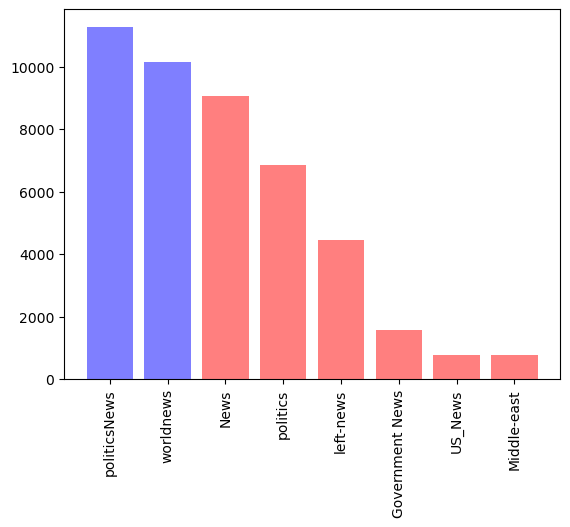

<Figure size 1200x600 with 0 Axes>

In [26]:
plt.bar(data_true['subject'].value_counts().index, data_true['subject'].value_counts().values, color='blue', alpha=0.5)
plt.bar(data_fake['subject'].value_counts().index, data_fake['subject'].value_counts().values, color='red', alpha=0.5)
plt.xticks(rotation=90)
plt.figure(figsize=(12, 6))
plt.show()

In [44]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label', 'Article',
       'Article_clean'],
      dtype='object')

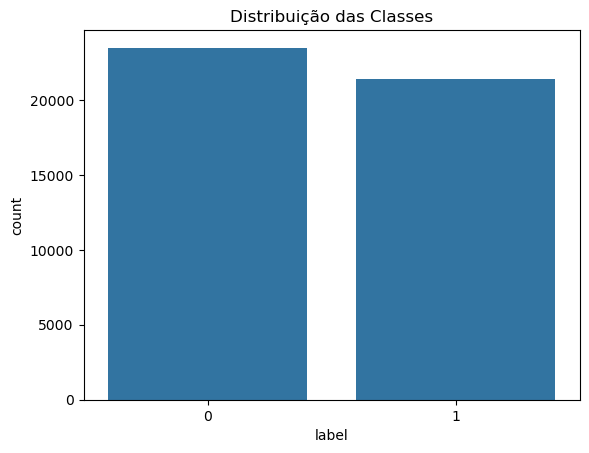

label
0    0.522985
1    0.477015
Name: proportion, dtype: float64


In [ ]:


# Contagem de cada classe
sns.countplot(x=df['label'])
plt.title("Distribuição das Classes")
plt.show()

# Proporção das classes
print(df['label'].value_counts(normalize=True))


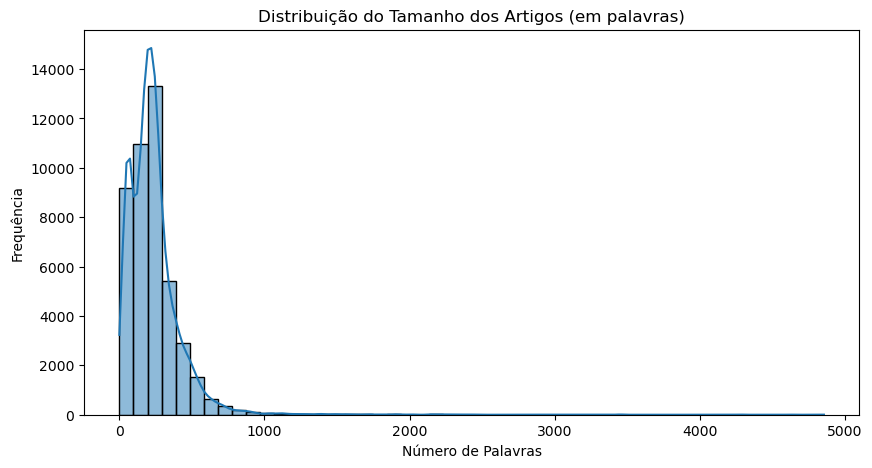

In [47]:
df["text_length"] = df["Article_clean"].apply(lambda x: len(x.split()))

# Histograma do comprimento dos textos
plt.figure(figsize=(10,5))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribuição do Tamanho dos Artigos (em palavras)")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.show()


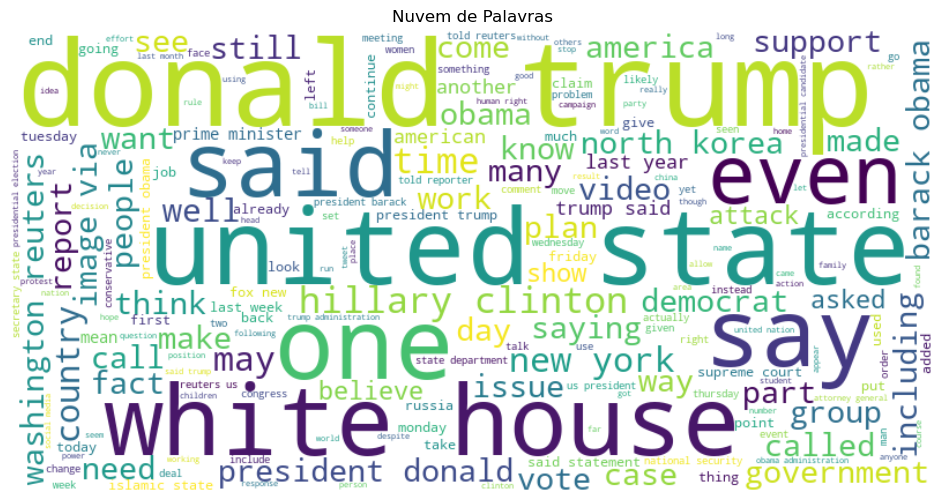

In [48]:
from wordcloud import WordCloud

# Juntar todos os textos
all_text = " ".join(df["Article_clean"])

# Gerar word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plotar a word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()


           word   count
331        said  130257
179       trump  128481
107          us   68267
218       would   55429
153   president   52672
223      people   41660
971         one   36304
379         new   32712
547       state   32338
882        also   31231
152       house   28935
330     reuters   28832
178      donald   28557
167     clinton   27441
344      states   27431
23        obama   27264
582  government   27162
187  republican   25336
12        could   24351
151       white   23872


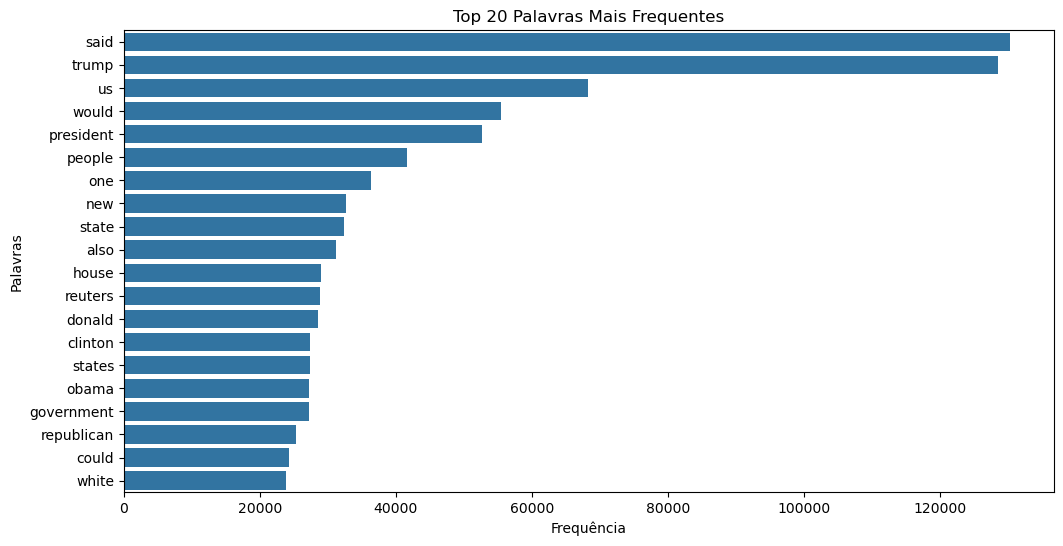

In [49]:
from collections import Counter

# Contar frequência de palavras
word_counts = Counter(all_text.split())

# Criar um DataFrame com as palavras mais frequentes
word_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)

# Exibir as 20 palavras mais frequentes
print(word_freq_df.head(20))

# Gráfico das palavras mais frequentes
plt.figure(figsize=(12, 6))
sns.barplot(x=word_freq_df["count"][:20], y=word_freq_df["word"][:20])
plt.title("Top 20 Palavras Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.show()


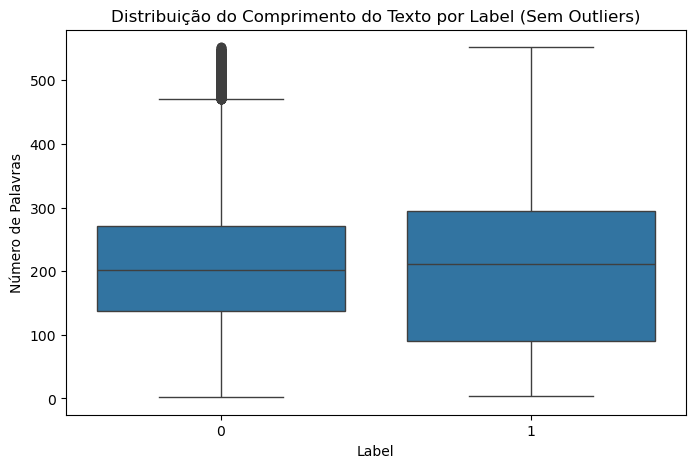

In [53]:

# Calcular Q1, Q3 e IQR
Q1 = np.percentile(df["text_length"], 25)
Q3 = np.percentile(df["text_length"], 75)
IQR = Q3 - Q1

# Definir limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar os dados removendo os outliers
df_filtered = df[(df["text_length"] >= lower_bound) & (df["text_length"] <= upper_bound)]

# Plotar boxplot sem outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered["label"], y=df_filtered["text_length"])
plt.title("Distribuição do Comprimento do Texto por Label (Sem Outliers)")
plt.xlabel("Label")
plt.ylabel("Número de Palavras")
plt.show()



Palavras mais frequentes em notícias falsas:
           word  count
13         said  99053
2         trump  47335
60           us  45175
64        would  31750
9       reuters  28464
11    president  26011
252       state  19381
290  government  18386
88        house  17844
26       states  17819
69          new  17661
674        also  15963
553  republican  15923
25       united  15622
52       people  15212
84         told  14285
145       could  13933
490         one  12788
459        last  12690
649      trumps  12435

Palavras mais frequentes em notícias verdadeiras:
          word  count
179      trump  81146
417       said  31204
153  president  26661
223     people  26448
218      would  23679
617        one  23516
107         us  23092
23       obama  19623
167    clinton  18975
178     donald  18054
250       like  17996
146      video  16125
30     hillary  15335
555       also  15268
970        new  15051
512       news  14986
493       even  13895
151      white  13615
255

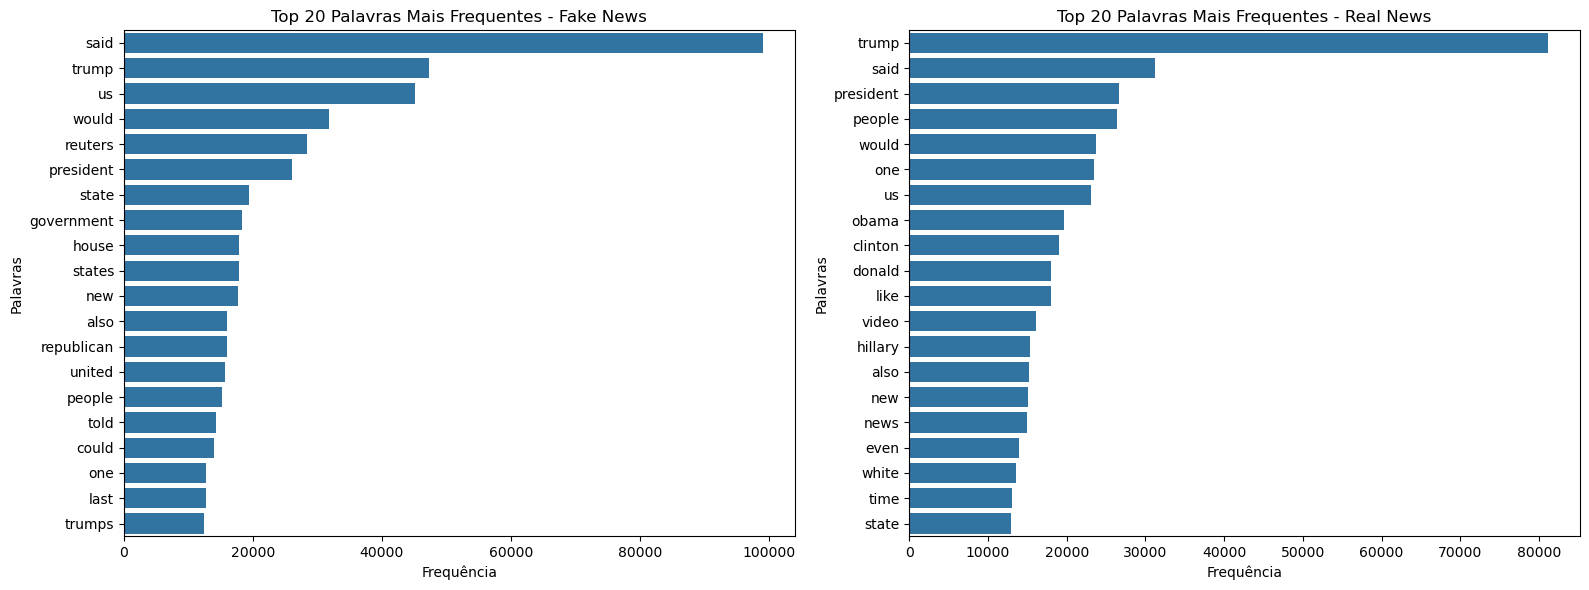

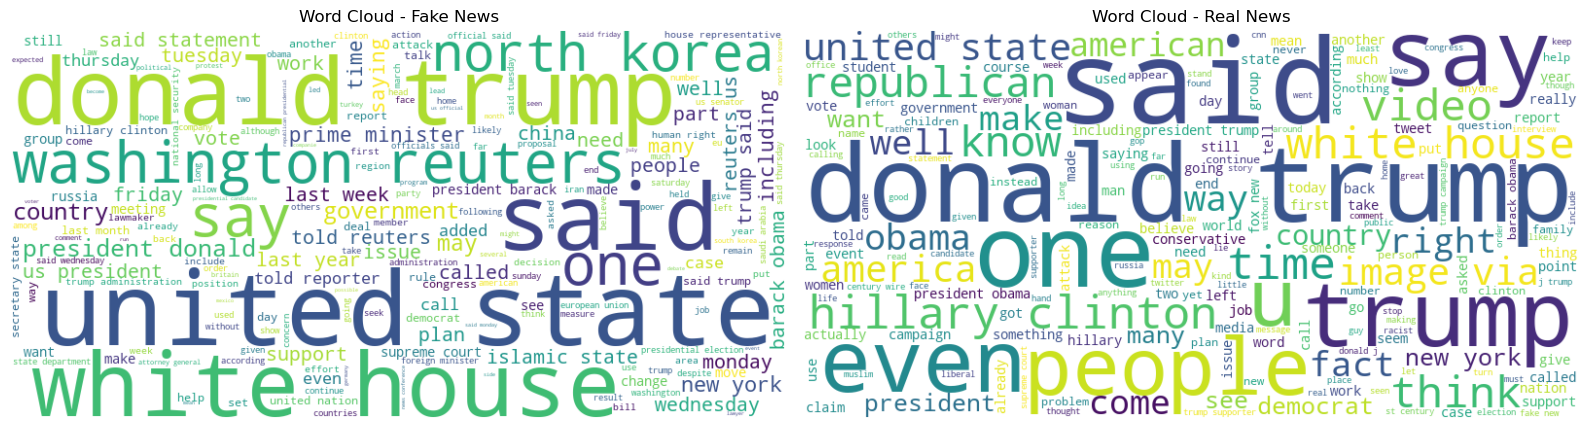

In [ ]:
# Separar artigos falsos e verdadeiros
fake_articles = " ".join(df[df["label"] == 1]["Article_clean"])
real_articles = " ".join(df[df["label"] == 0]["Article_clean"])

# Contar frequência de palavras para cada categoria
fake_word_counts = Counter(fake_articles.split())
real_word_counts = Counter(real_articles.split())

# Criar DataFrames com as palavras mais frequentes
fake_word_freq_df = pd.DataFrame(fake_word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)
real_word_freq_df = pd.DataFrame(real_word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)


# Criar gráficos para cada categoria
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=fake_word_freq_df["count"][:20], y=fake_word_freq_df["word"][:20], ax=axes[0])
axes[0].set_title("Top 20 Palavras Mais Frequentes - Fake News")
axes[0].set_xlabel("Frequência")
axes[0].set_ylabel("Palavras")

sns.barplot(x=real_word_freq_df["count"][:20], y=real_word_freq_df["word"][:20], ax=axes[1])
axes[1].set_title("Top 20 Palavras Mais Frequentes - Real News")
axes[1].set_xlabel("Frequência")
axes[1].set_ylabel("Palavras")

plt.tight_layout()
plt.show()

# Gerar word clouds
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_articles)
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_articles)

# Mostrar word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(fake_wordcloud, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Word Cloud - Fake News")

axes[1].imshow(real_wordcloud, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Word Cloud - Real News")

plt.tight_layout()
plt.show()


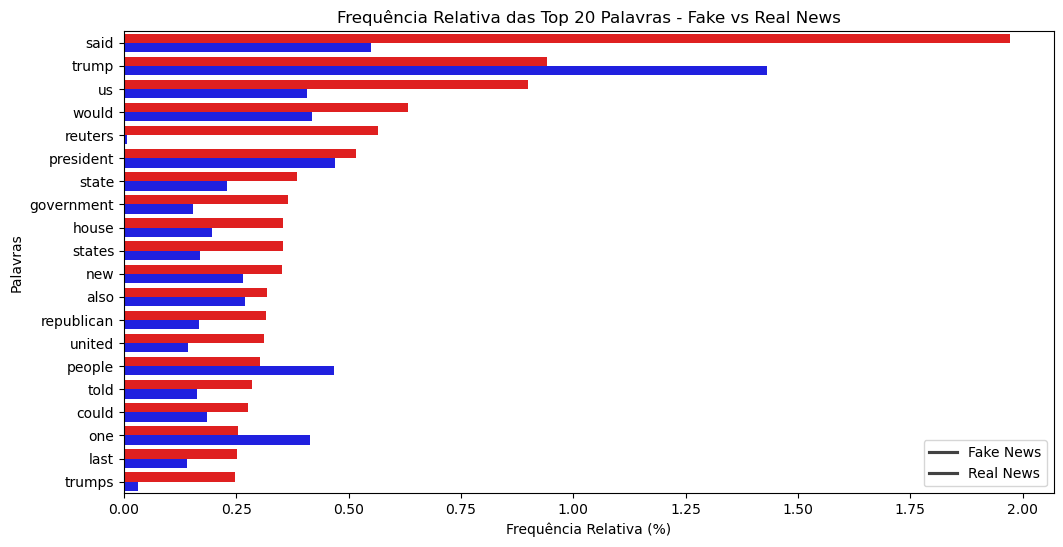

In [ ]:

fake_articles = " ".join(df[df["label"] == 1]["Article_clean"])
real_articles = " ".join(df[df["label"] == 0]["Article_clean"])


fake_word_counts = Counter(fake_articles.split())
real_word_counts = Counter(real_articles.split())

total_fake_words = sum(fake_word_counts.values())
total_real_words = sum(real_word_counts.values())


fake_word_freq_df = pd.DataFrame(
    {"word": list(fake_word_counts.keys()), 
     "relative_freq": [count / total_fake_words * 100 for count in fake_word_counts.values()]
    }
).sort_values(by="relative_freq", ascending=False)

real_word_freq_df = pd.DataFrame(
    {"word": list(real_word_counts.keys()), 
     "relative_freq": [count / total_real_words * 100 for count in real_word_counts.values()]
    }
).sort_values(by="relative_freq", ascending=False)


merged_freq = pd.merge(fake_word_freq_df, real_word_freq_df, on="word", suffixes=("_fake", "_real"))


top_words = merged_freq.nlargest(20, "relative_freq_fake")

plt.figure(figsize=(12, 6))
sns.barplot(data=top_words.melt(id_vars="word", var_name="category", value_name="percentage"),
            x="percentage", y="word", hue="category", palette=["red", "blue"])

plt.title("Frequência Relativa das Top 20 Palavras - Fake vs Real News")
plt.xlabel("Frequência Relativa (%)")
plt.ylabel("Palavras")
plt.legend(["Fake News", "Real News"])
plt.show()


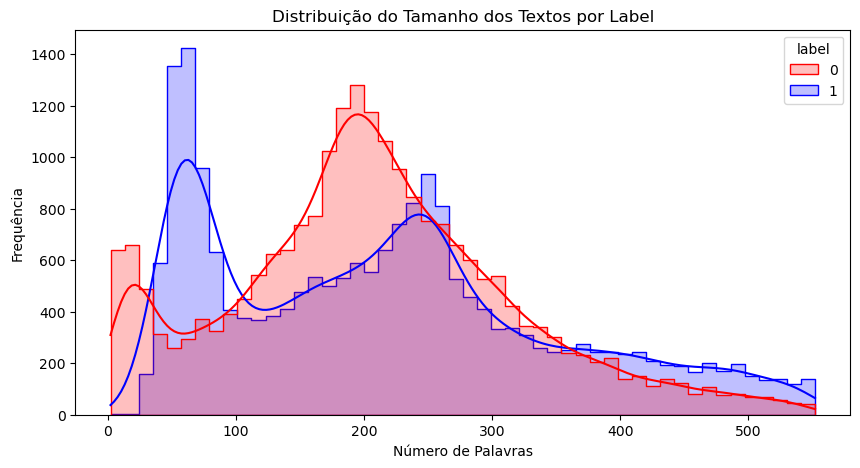

In [54]:
plt.figure(figsize=(10,5))
sns.histplot(df_filtered, x="text_length", hue="label", bins=50, kde=True, element="step", palette=["red", "blue"])
plt.title("Distribuição do Tamanho dos Textos por Label")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.show()


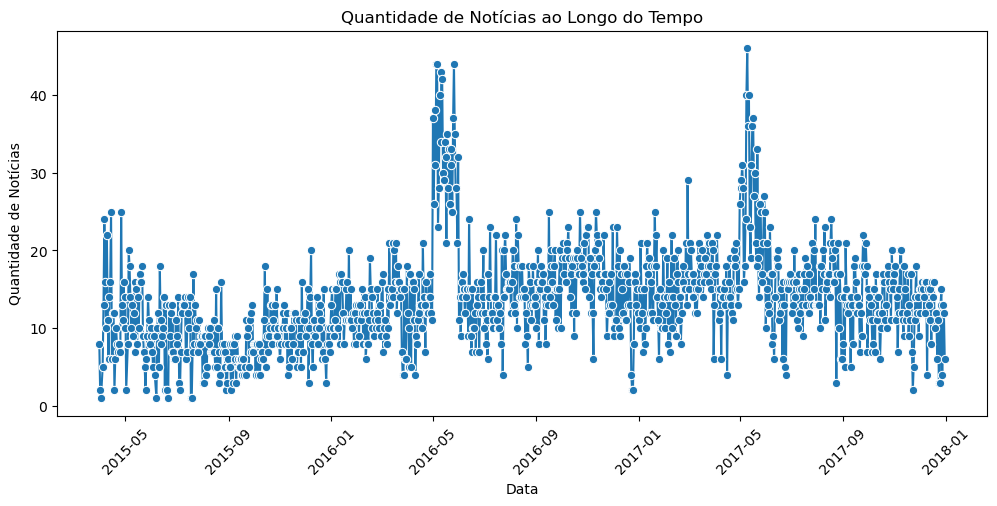

In [56]:
# Converter 'date' para datetime se necessário
df["date"] = pd.to_datetime(df["date"], errors='coerce')

# Contar notícias por data
df_date_counts = df.groupby("date").size().reset_index(name="count")

# Plotar tendência temporal
plt.figure(figsize=(12, 5))
sns.lineplot(x=df_date_counts["date"], y=df_date_counts["count"], marker="o")
plt.title("Quantidade de Notícias ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Quantidade de Notícias")
plt.xticks(rotation=45)
plt.show()


In [57]:
from sklearn.feature_extraction.text import CountVectorizer

# Criar bigramas e trigramas
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words="english")
X = vectorizer.fit_transform(df["Article_clean"])

# Contar a frequência
ngram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Exibir os 10 mais comuns
print(ngram_counts.head(10))


MemoryError: Unable to allocate 3.49 TiB for an array with shape (44898, 10677975) and data type int64

In [ ]:
# Criar mapa de calor
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação Entre as Variáveis")
plt.show()


# Tokenização para o treino

In [29]:


# Tokenização: converte os textos em uma matriz de contagem de termos
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["Article_clean"])
y = df["label"]

# Divisão de dados e treinamento com Naive Bayes

In [30]:
# Divide os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Criação e treinamento do classificador Naive Bayes (utilizando ComplementNB)
clf = ComplementNB()
clf.fit(X_train, y_train)

# Realiza predições para os dados de teste
y_pred = clf.predict(X_test)

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
mcc = matthews_corrcoef(y_test, y_pred)
print("Coeficiente de Correlação de Matthews (MCC):", mcc)
clf_acc = accuracy_score(y_test, y_pred)
print("\nAcurácia:", clf_acc)


Matriz de Confusão:
[[4475  192]
 [ 141 4172]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4667
           1       0.96      0.97      0.96      4313

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

Coeficiente de Correlação de Matthews (MCC): 0.9258129112265807

Acurácia: 0.9629175946547884


In [32]:
mltn = MultinomialNB()
mltn.fit(X_train, y_train)


y_pred = mltn.predict(X_test)
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Após obter as predições (y_pred) e os valores reais (y_test):
mcc = matthews_corrcoef(y_test, y_pred)
print("Coeficiente de Correlação de Matthews (MCC):", mcc)

mltn_acc = accuracy_score(y_test, y_pred)
print("\nAcurácia:", mltn_acc)

Matriz de Confusão:
[[4475  192]
 [ 141 4172]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4667
           1       0.96      0.97      0.96      4313

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

Coeficiente de Correlação de Matthews (MCC): 0.9258129112265807

Acurácia: 0.9629175946547884


In [33]:
acc = clf_acc - mltn_acc
acc

0.0

In [34]:
from sklearn.metrics import precision_score

# Para o classificador ComplementNB
precision = precision_score(y_test, y_pred, average='binary')
print("Precision (ComplementNB):", precision)

# Para o classificador MultinomialNB
precision_multinomial = precision_score(y_test, mltn.predict(X_test))
print("Precision (MultinomialNB):", precision_multinomial)

Precision (ComplementNB): 0.9560036663611365
Precision (MultinomialNB): 0.9560036663611365


In [35]:


# Após obter as predições (y_pred) e os valores reais (y_test):
mcc = matthews_corrcoef(y_test, y_pred)
print("Coeficiente de Correlação de Matthews (MCC):", mcc)


Coeficiente de Correlação de Matthews (MCC): 0.9258129112265807


In [36]:
print(classification_report(y_test, y_pred, target_names=['Fake', 'True'], digits=4))

              precision    recall  f1-score   support

        Fake     0.9695    0.9589    0.9641      4667
        True     0.9560    0.9673    0.9616      4313

    accuracy                         0.9629      8980
   macro avg     0.9627    0.9631    0.9629      8980
weighted avg     0.9630    0.9629    0.9629      8980



In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
roc_auc = roc_auc_score(y_test, y_probs)
print("AUC-ROC:", roc_auc)

from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print("AUC-PR:", pr_auc)

AUC-ROC: 0.9837433691306836
AUC-PR: 0.9824700652684112


In [38]:
from sklearn.metrics import log_loss
loss = log_loss(y_test, y_probs)
print("Log Loss:", loss)

Log Loss: 0.8091774275304752


In [39]:
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print(f"Acurácia Treino: {train_acc}, Acurácia Teste: {test_acc}")

Acurácia Treino: 0.9691241160420959, Acurácia Teste: 0.9629175946547884


In [40]:
feature_names = vectorizer.get_feature_names_out()
coefs = clf.feature_log_prob_[1]  # Coeficientes da classe "verdadeira"
top_features = sorted(zip(coefs, feature_names), reverse=True)[:10]
print("Top 10 palavras preditivas:", top_features)

Top 10 palavras preditivas: [(15.37380274406949, 'zzzzzzzzzzzzz'), (15.37380274406949, 'zyuseragentifzxzbreak'), (15.37380274406949, 'zyuganov'), (15.37380274406949, 'zyries'), (15.37380274406949, 'zypries'), (15.37380274406949, 'zwolinskis'), (15.37380274406949, 'zwolinski'), (15.37380274406949, 'zweli'), (15.37380274406949, 'zweiman'), (15.37380274406949, 'zweig')]


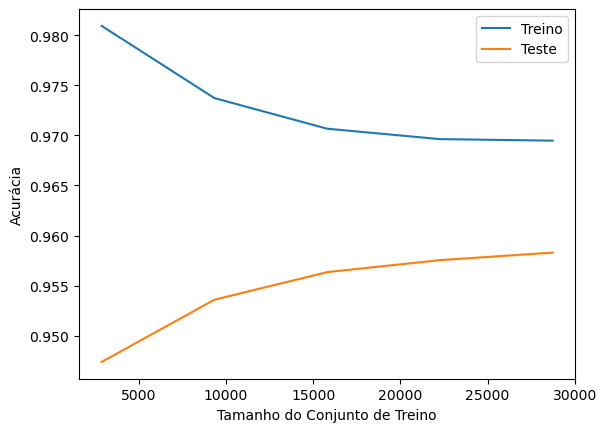

In [41]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Treino')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Teste')
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Acurácia')
plt.legend()

In [42]:
from scipy.stats import ks_2samp
ks_stat, p_value = ks_2samp(y_probs[y_test == 0], y_probs[y_test == 1])
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

KS Statistic: 0.9263792608103097, p-value: 0.0
